<a href="https://colab.research.google.com/github/weehwa/ctscan_cnn_model_covid/blob/main/Project_Script_(Ang_Wee_Hwa).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Problem Statement:**

**To Predict if the CT Scan is positive or negative cases of Covid.**

Covid19 had been a issue with the world, as the virus had affected varies countires around the global. Buisnesses and individuals are lossing customers as governments are issuing stricter measures to counter and prevent the spread of the virus. 

For this project, we will be focusing on Convolutional neural network(CNN) to predict if the CT Scan image is a positive or Negative case of Covid19.

Data:\
For this predictive model we downloaded the data from kaggle ref: https://www.kaggle.com/c/covidct \
We have a total of: \
- Covid CT Scan Images: 1252 (png)
- Non-Covid CT Scan Images: 1230 (png)

We will divide them into 3 folders manually: \
1) train: (to train the model)
- Covid: 992 images
- Non-Covid: 975 images

2) val: (to validite the model after each epoch)
- COVID: 248 images
- Non-Covid: 244 images

3) test: (to manually test and observe the result)
- COVID : 12 images
- Non-Covid : 10 images 

We will break into 3 Parts for this project namely:\
Part A : Observe the CT Scan and to deferentiate the difference visually. \
Part B : We wil test our 3 models namely:\
1) VGG16\
2) InterceptionV3\
3) Resnet50\
and select the best one for hyperparameter tuning.\
Part C : We wil use the best mdoel to fine tune the training rate and use the best model. 

To aviod bias, we will be using 50 epoch to train all the models and confusion metrix from prediction of the test dataset. Accuracy and validity acccuracy are the measurements for the performance of the model.

**Import Libaries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.metrics import binary_crossentropy
from keras.optimizers import Adam
from keras.applications import resnet50, vgg16, inception_v3
from matplotlib import pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix
import itertools
from google.colab import drive 
%matplotlib inline

**Establish connection with google drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Creating Functions**

In [ ]:
# function to plot image

def plot_image(imgs, figsize=(12,6), rows=1, interp=False, titles=None):
  if type(imgs[0]) is np.ndarray:
    imgs = np.array(imgs).astype(np.uint8)
    if (imgs.shape[-1] != 3):
      imgs = imgs.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  cols = len(imgs)//rows if len(imgs) % 2 == 0 else len(imgs)//rows + 1
  for i in range(len(imgs)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(imgs[i], interpolation=None if interp else 'none')

# function to show image    
def show_image(file): 
    image = imread(file) # read dir file 
    plt.image.imshow(image) # show image
    plt.title(file) # set title
    plt.show() # show iamge
    
# From https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
# To plot confusion matrix
    
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axies=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[j,i],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

**Check Data**

In [ ]:
# import files from google drive
folder = '/content/drive/My Drive/dataset_(Ang_Wee_Hwa)/data/'
filepath = folder + 'train/COVID/Covid (1).png' # select image path and store in a variable
image = imread(filepath) # read image
image.shape # observe shape

(202, 256, 3)

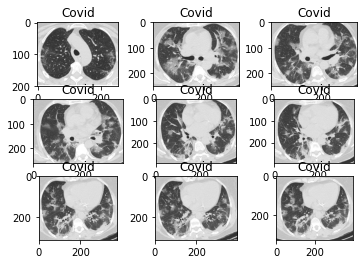

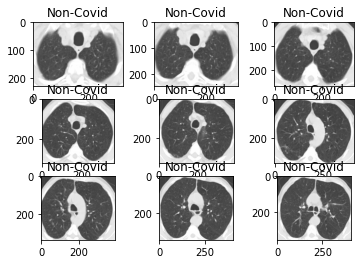

In [ ]:
# for loop to loop image 1 to 9 for covid image
for img in range(1,10,1): # as file name starts with 1 rather than 0
        plt.subplot(330 + img)
        filename = folder + 'train/COVID/Covid (' + str(img) +').png'
        imgs = imread(filename)
        plt.imshow(imgs)
        plt.title('Covid')
plt.show()

# for loop to loop image 1 to 9 for Non-covid image
for img in range(1,10,1):
        plt.subplot(330 + img)
        filename = folder + 'train/Non-COVID/Non-Covid (' + str(img) +').png'
        imgs = imread(filename)
        plt.imshow(imgs)
        plt.title('Non-Covid')
plt.show()

**Observation** \
From the images we can spot that Non-Covid CTScan have clear lungs wheras Covid CTScan have white portions in the lung

#**Image Augmentation**
 ******This Part is to showcase image augmentation and is not part of the code for the study******\
For Image augmentation we will use: \
Rotation Range = 20 degrees on random\
Width Shift range = 0.2 of total image on random\
Height Shift Range = 0.2 of total image on random\
Horizontal Flip = Randomly flip the image horizontally

In [ ]:
img_aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                     width_shift_range=0.2,
                                                     height_shift_range=0.2,
                                                     horizontal_flip=True)\
.flow_from_directory(folder + 'train/',target_size = (224,224), batch_size=5)

Found 1967 images belonging to 2 classes.


In [ ]:
imgs, labels = next(img_aug)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


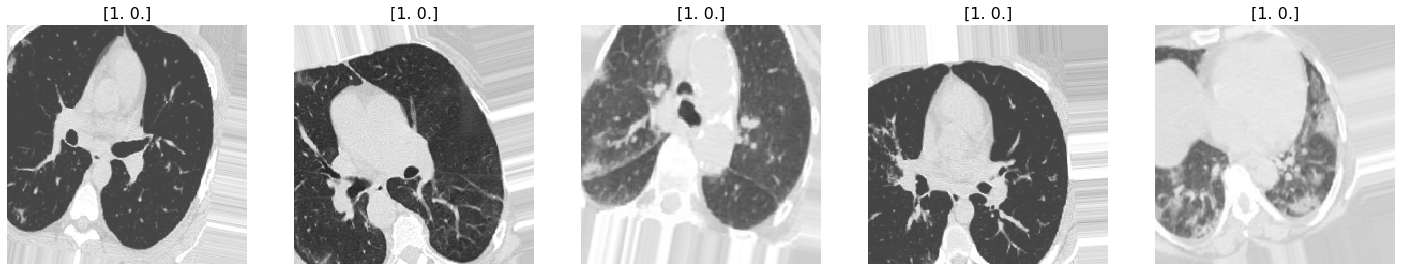

In [ ]:
# observe train image after pre processing
plot_image(imgs, figsize = (30,5), titles=labels)

** ***End of Showcase for image augmentation*** **

# **VGG16**

**Preprocessing for VGG16**

Use vgg16 as application for data preprocessing, 
we will use data generator to do image augmentation.

In [ ]:
# use image generator to preprocess target size to (224,244) with batch size 32
# prepare data for train, test and predict where predict shuffle=False,
# so we can observe the result after prediction
train_vgg = keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                     featurewise_std_normalization=True,
                                                     rotation_range=20,
                                                     width_shift_range=0.2,
                                                     height_shift_range=0.2,
                                                     horizontal_flip=True,
                                                     preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                                                     .flow_from_directory(folder + 'train/',target_size = (224,224), batch_size=32)
val_vgg = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(folder + 'val/',target_size = (224,224), batch_size=32)
test_vgg = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(folder + 'test/',target_size = (224,224), batch_size=32,shuffle=False)

Found 1967 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train_vgg)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


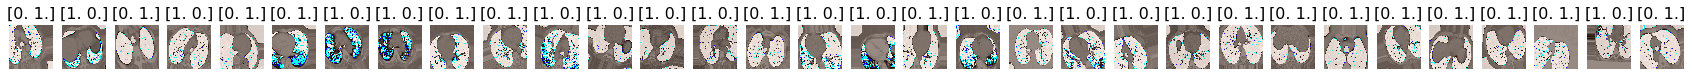

In [ ]:
# observe train image after pre processing
plot_image(imgs, titles=labels, figsize = (30,5))

In [ ]:
# identify classifier
classifier_vgg = tf.keras.applications.VGG16(
              include_top=False,
              weights="imagenet",
              input_shape=(224,224,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)

In [ ]:
# add new classifier layers
flat1 = Flatten()(classifier_vgg.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_vgg = Model(inputs=classifier_vgg.inputs, outputs=output)


In [ ]:
classifier_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# compile classifier and add parimeters
classifier_vgg.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# fit classifer
history_vgg = classifier_vgg.fit(train_vgg, 
                                validation_data= val_vgg, 
                                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
62/62 [==============================] - 41s 556ms/step - loss: 0.8496 - accuracy: 0.5521 - val_loss: 0.6929 - val_accuracy: 0.4959
Epoch 2/50
62/62 [==============================] - 32s 512ms/step - loss: 0.6920 - accuracy: 0.5382 - val_loss: 0.6850 - val_accuracy: 0.6280
Epoch 3/50
62/62 [==============================] - 32s 512ms/step - loss: 0.6705 - accuracy: 0.6099 - val_loss: 0.6887 - val_accuracy: 0.4980
Epoch 4/50
62/62 [==============================] - 32s 512ms/step - loss: 0.6055 - accuracy: 0.6331 - val_loss: 0.5427 - val_accuracy: 0.7053
Epoch 5/50
62/62 [==============================] - 32s 511ms/step - loss: 0.3675 - accuracy: 0.8575 - val_loss: 0.7432 - val_accuracy: 0.6748
Epoch 6/50
62/62 [==============================] - 32s 520ms/step - loss: 0.4284 - accuracy: 0.7951 - val_loss: 0.4689 - val_accuracy: 0.7398
Epoch 7/50
62/62 [==============================] - 33s 526ms/step - loss: 0.2978 - accuracy: 0.8906 - val_loss: 0.4492 - val_accuracy: 0.7785

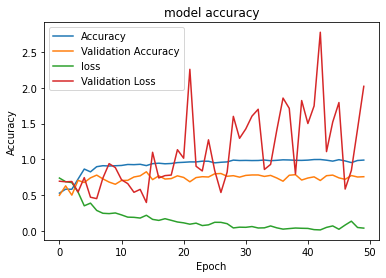

In [ ]:
# plot accuracy and losses 
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Observation:**\
From the graph we can observe that on the 28 epoch the model is performing the best with \
Accuracy: 95.19%\
Val_accuracy: 76.22%

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


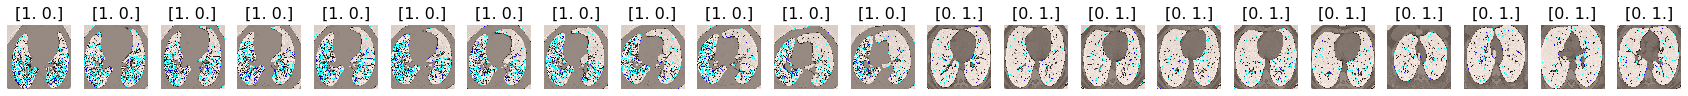

In [ ]:
# plot predicting varaible images
pred_imgs, pred_labels = next(test_vgg)
plot_image(pred_imgs, titles=pred_labels,figsize=(30,5))

In [ ]:
# predict the predict images
pred = classifier_vgg.predict(x=test_vgg, verbose=0)

In [ ]:
# see result of prediction
np.round(pred)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true = test_vgg.classes,y_pred = np.argmax(pred, axis=1))

In [ ]:
# observe the label
test_vgg.class_indices

{'COVID': 0, 'Non-COVID': 1}

Confusion Matrix, without normalization
[[10  2]
 [ 0 10]]


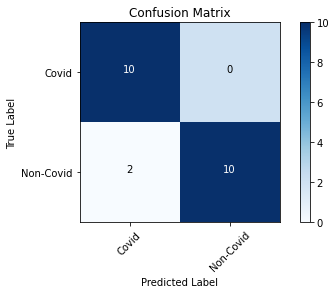

In [ ]:
# plot confusion metrix to visualise result with function
cm_plot_labels = ['Covid', 'Non-Covid']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title= 'Confusion Matrix')

**Observation:**\
The model incorectly predicted 2 non-covid cases as covid cases. 

#**Inteception V3**

Preprocessing for Inteception V3
Use Inteception V3 as application for data preprocessing we will use data generator to do image augmentation.

In [ ]:
# use image generator to preprocess target size to (299,299) with batch size 32
# prepare data for train, test and predict where predict shuffle=False,
# so we can observe the result after prediction
train_int = keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                     featurewise_std_normalization=True,
                                                     rotation_range=20,
                                                     width_shift_range=0.2,
                                                     height_shift_range=0.2,
                                                     horizontal_flip=True,
                                                     preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)\
                                                     .flow_from_directory(folder + 'train/',target_size = (299,299), batch_size=32)
val_int = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)\
.flow_from_directory(folder + 'val/',target_size = (299,299), batch_size=32)
test_int = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)\
.flow_from_directory(folder + 'test/',target_size = (299,299), batch_size=32,shuffle=False)

Found 1967 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train_int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


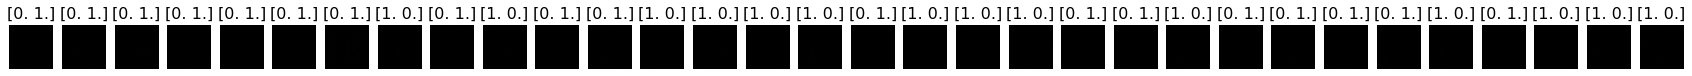

In [ ]:
# observe train image after pre processing
plot_image(imgs, titles=labels, figsize = (30,5))

In [ ]:
# identify classifer
classifier_int = tf.keras.applications.InceptionV3(
              include_top=False,
              weights="imagenet",
              input_shape=(299,299,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
# add new classifier layers
flat1 = Flatten()(classifier_int.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_int = Model(inputs=classifier_int.inputs, outputs=output)

In [ ]:
classifier_int.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
# compile classifer 
classifier_int.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# fit classifer 
history_int = classifier_int.fit(train_int, 
                                validation_data= val_int, 
                                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
62/62 [==============================] - 57s 798ms/step - loss: 0.4264 - accuracy: 0.7719 - val_loss: 2.1929 - val_accuracy: 0.5325
Epoch 2/50
62/62 [==============================] - 47s 762ms/step - loss: 0.1153 - accuracy: 0.9614 - val_loss: 2.9469 - val_accuracy: 0.5711
Epoch 3/50
62/62 [==============================] - 46s 745ms/step - loss: 0.0884 - accuracy: 0.9658 - val_loss: 2.2073 - val_accuracy: 0.6321
Epoch 4/50
62/62 [==============================] - 47s 750ms/step - loss: 0.0641 - accuracy: 0.9764 - val_loss: 1.5948 - val_accuracy: 0.6768
Epoch 5/50
62/62 [==============================] - 47s 754ms/step - loss: 0.0642 - accuracy: 0.9775 - val_loss: 1.0566 - val_accuracy: 0.7358
Epoch 6/50
62/62 [==============================] - 46s 739ms/step - loss: 0.0363 - accuracy: 0.9849 - val_loss: 1.2818 - val_accuracy: 0.6972
Epoch 7/50
62/62 [==============================] - 46s 740ms/step - loss: 0.0502 - accuracy: 0.9794 - val_loss: 0.9649 - val_accuracy: 0.7642

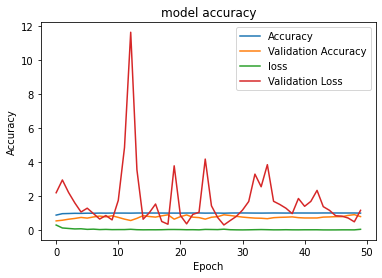

In [ ]:
# plot accuracy vs loss
plt.plot(history_int.history["accuracy"])
plt.plot(history_int.history['val_accuracy'])
plt.plot(history_int.history['loss'])
plt.plot(history_int.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Observation:**\
From the graph we can observe that on the 49 epoch the model is performing the best with \
Accuracy: 99.99%\
Val_accuracy: 90.04%


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


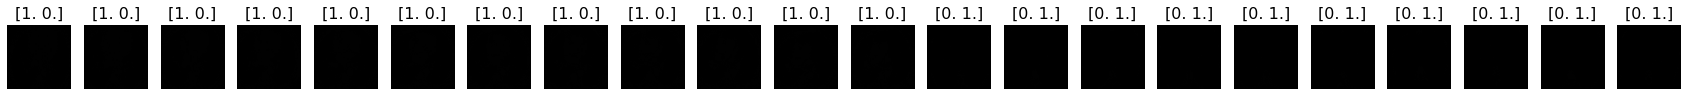

In [ ]:
# plot predicting varaible images
pred_imgs, pred_labels = next(test_int)
plot_image(pred_imgs, titles=pred_labels,figsize=(30,5))

In [ ]:
# predict the predict images
pred = classifier_int.predict(x=test_int, verbose=0)

In [ ]:
# see result of prediction
np.round(pred)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true = test_int.classes,y_pred = np.argmax(pred, axis=1))

Confusion Matrix, without normalization
[[12  0]
 [ 0 10]]


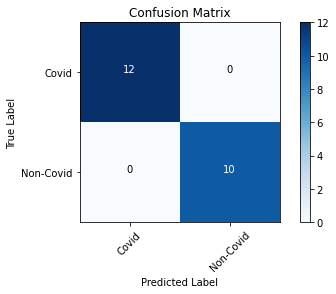

In [ ]:
# plot confusion metrix to visualise result with function
cm_plot_labels = ['Covid', 'Non-Covid']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title= 'Confusion Matrix')

**Obseravtion:**\
The model successfully predicts all Covid and Non Covid cases.

#**Inteception Resnet50** 

Preprocessing for resnet
Use resnet50 as application for data preprocessing we will use data generator to do image augmentation.

In [ ]:
# use image generator to preprocess target size to (224,244) with batch size 32
# prepare data for train, test and predict where predict shuffle=False,
# so we can observe the result after prediction
train_res = keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                     featurewise_std_normalization=True,
                                                     rotation_range=20,
                                                     width_shift_range=0.2,
                                                     height_shift_range=0.2,
                                                     horizontal_flip=True,
                                                     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                                                     .flow_from_directory(folder + 'train/',target_size = (224,224), batch_size=32)
val_res = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(folder + 'val/',target_size = (224,224), batch_size=32)
test_res = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(folder + 'test/',target_size = (224,224), batch_size=32,shuffle=False)

Found 1967 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train_res)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


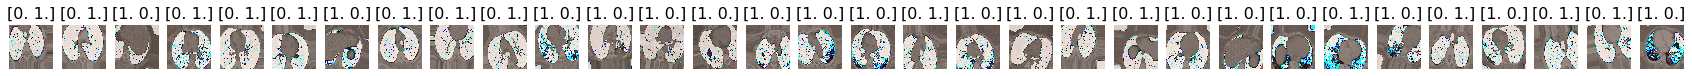

In [ ]:
# observe train image after pre processing
plot_image(imgs, titles=labels, figsize = (30,5))

In [ ]:
# identify classifier
classifier_res = tf.keras.applications.ResNet50(
              include_top=False,
              weights="imagenet",
              input_shape=(224,224,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)

In [ ]:
# add new classifier layers
flat1 = Flatten()(classifier_res.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_res = Model(inputs=classifier_res.inputs, outputs=output)

In [ ]:
classifier_res.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# compilt classifer
classifier_res.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# fit classifier
history_res = classifier_res.fit(train_res, 
                                validation_data= val_res, 
                                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
62/62 [==============================] - 41s 561ms/step - loss: 0.3901 - accuracy: 0.8097 - val_loss: 2.4229 - val_accuracy: 0.6423
Epoch 2/50
62/62 [==============================] - 34s 546ms/step - loss: 0.1158 - accuracy: 0.9574 - val_loss: 3.7179 - val_accuracy: 0.6321
Epoch 3/50
62/62 [==============================] - 34s 546ms/step - loss: 0.0914 - accuracy: 0.9672 - val_loss: 5.2653 - val_accuracy: 0.6748
Epoch 4/50
62/62 [==============================] - 34s 547ms/step - loss: 0.0842 - accuracy: 0.9675 - val_loss: 3.5872 - val_accuracy: 0.6321
Epoch 5/50
62/62 [==============================] - 34s 555ms/step - loss: 0.0363 - accuracy: 0.9906 - val_loss: 1.8753 - val_accuracy: 0.6870
Epoch 6/50
62/62 [==============================] - 34s 548ms/step - loss: 0.0583 - accuracy: 0.9788 - val_loss: 2.0068 - val_accuracy: 0.6341
Epoch 7/50
62/62 [==============================] - 34s 546ms/step - loss: 0.0455 - accuracy: 0.9865 - val_loss: 1.3430 - val_accuracy: 0.7866

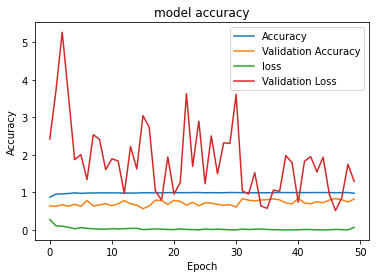

In [ ]:
plt.plot(history_res.history["accuracy"])
plt.plot(history_res.history['val_accuracy'])
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Observation:**\
From the graph we can observe that on the 47 epoch the model is performing the best with \
Accuracy: 99.29%\
Val_accuracy: 83.94%

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


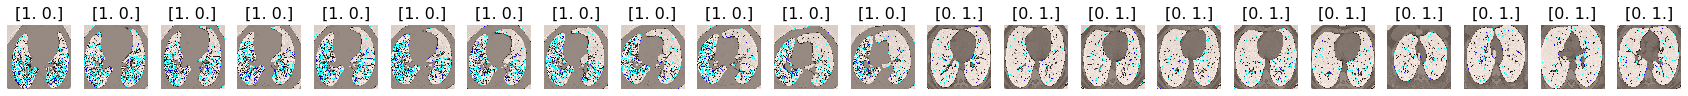

In [ ]:
# plot predicting varaible images
pred_imgs, pred_labels = next(test_res)
plot_image(pred_imgs, titles=pred_labels,figsize=(30,5))

In [ ]:
# predict the predict images
pred = classifier_res.predict(x=test_int, verbose=0)

In [ ]:
# see result of prediction
np.round(pred)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true = test_res.classes,y_pred = np.argmax(pred, axis=1))

Confusion Matrix, without normalization
[[ 0 12]
 [ 0 10]]


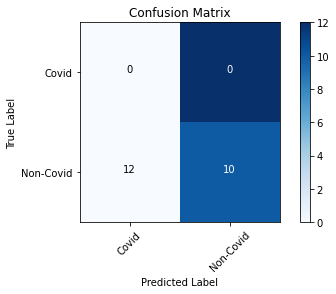

In [ ]:
# plot confusion metrix to visualise result with function
cm_plot_labels = ['Covid', 'Non-Covid']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title= 'Confusion Matrix')

**Observation:** \
The model predicts all cases to be Covid cases. 

# **Hyperparameter Tuning**

From the testing models, i have the best model which is the interception V3 model with the highest prediction rate. Hence we will use interceptionv3 for hyper parimeter tuning with the data prepared ealier: train_int, val_int and test_int. We will use these datas for training and manupilate the training rate to observe which gives a better result. Previouly we had tried 0.0001, hence we will try with:\
1) 0.001\
2) 0.01\
3) 0.1


to observe which performs better 

**Test with learning rate: 0.001**

In [ ]:
# identify classifer
classifier_int = tf.keras.applications.InceptionV3(
              include_top=False,
              weights="imagenet",
              input_shape=(299,299,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)
# add new classifier layers
flat1 = Flatten()(classifier_int.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_int = Model(inputs=classifier_int.inputs, outputs=output)

In [ ]:
classifier_int.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_int_1 = classifier_int.fit(train_int, 
                                validation_data= val_int, 
                                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
62/62 [==============================] - 58s 825ms/step - loss: 0.3661 - accuracy: 0.8800 - val_loss: 6.6140 - val_accuracy: 0.4715
Epoch 2/50
62/62 [==============================] - 50s 807ms/step - loss: 0.2123 - accuracy: 0.9123 - val_loss: 125.5019 - val_accuracy: 0.5610
Epoch 3/50
62/62 [==============================] - 50s 809ms/step - loss: 0.2288 - accuracy: 0.9128 - val_loss: 41.6340 - val_accuracy: 0.5732
Epoch 4/50
62/62 [==============================] - 50s 801ms/step - loss: 0.1511 - accuracy: 0.9424 - val_loss: 260.5606 - val_accuracy: 0.5041
Epoch 5/50
62/62 [==============================] - 50s 798ms/step - loss: 0.1807 - accuracy: 0.9407 - val_loss: 20.6600 - val_accuracy: 0.6728
Epoch 6/50
62/62 [==============================] - 49s 789ms/step - loss: 0.1312 - accuracy: 0.9592 - val_loss: 0.4773 - val_accuracy: 0.8191
Epoch 7/50
62/62 [==============================] - 50s 809ms/step - loss: 0.0979 - accuracy: 0.9661 - val_loss: 0.5899 - val_accuracy: 

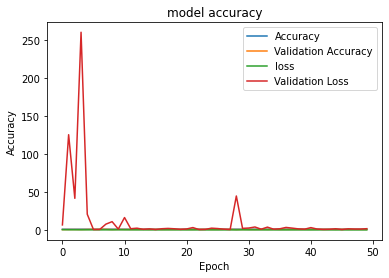

In [ ]:
plt.plot(history_int_1.history["accuracy"])
plt.plot(history_int_1.history['val_accuracy'])
plt.plot(history_int_1.history['loss'])
plt.plot(history_int_1.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Observation:**\
From the graph we can observe that on the 46 epoch the model is performing the best with \
Accuracy: 99.18%\
Val_accuracy: 86.99%

**Test with learning rate: 0.01**

In [ ]:
# identify classifer
classifier_int = tf.keras.applications.InceptionV3(
              include_top=False,
              weights="imagenet",
              input_shape=(299,299,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)
# add new classifier layers
flat1 = Flatten()(classifier_int.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_int = Model(inputs=classifier_int.inputs, outputs=output)

In [ ]:
classifier_int.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_int_2 = classifier_int.fit(train_int, 
                                validation_data= val_int, 
                                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
62/62 [==============================] - 54s 776ms/step - loss: 0.5877 - accuracy: 0.8099 - val_loss: 41307796.0000 - val_accuracy: 0.5041
Epoch 2/50
62/62 [==============================] - 46s 748ms/step - loss: 0.3602 - accuracy: 0.8600 - val_loss: 64.5085 - val_accuracy: 0.6179
Epoch 3/50
62/62 [==============================] - 48s 774ms/step - loss: 0.2902 - accuracy: 0.8725 - val_loss: 0.7739 - val_accuracy: 0.7602
Epoch 4/50
62/62 [==============================] - 49s 782ms/step - loss: 0.3237 - accuracy: 0.8864 - val_loss: 0.7006 - val_accuracy: 0.7744
Epoch 5/50
62/62 [==============================] - 49s 782ms/step - loss: 0.2907 - accuracy: 0.8787 - val_loss: 2.0360 - val_accuracy: 0.7785
Epoch 6/50
62/62 [==============================] - 48s 779ms/step - loss: 0.3010 - accuracy: 0.8650 - val_loss: 19.8402 - val_accuracy: 0.5041
Epoch 7/50
62/62 [==============================] - 48s 781ms/step - loss: 0.3049 - accuracy: 0.8790 - val_loss: 0.8307 - val_accurac

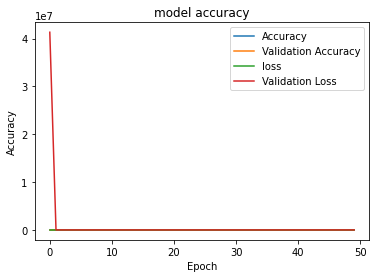

In [ ]:
plt.plot(history_int_2.history["accuracy"])
plt.plot(history_int_2.history['val_accuracy'])
plt.plot(history_int_2.history['loss'])
plt.plot(history_int_2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Observation:**\
we can observe that on the 50 epoch, training accuracy increases while validity is volatile but increasing slowly towards the end, the model is performing the best with \
Accuracy: 97.37%\
Val_accuracy: 80.49%

**Test with learning rate: 0.1**

In [ ]:
# identify classifer
classifier_int = tf.keras.applications.InceptionV3(
              include_top=False,
              weights="imagenet",
              input_shape=(299,299,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)
# add new classifier layers
flat1 = Flatten()(classifier_int.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_int = Model(inputs=classifier_int.inputs, outputs=output)

In [ ]:
classifier_int.compile(optimizer=Adam(learning_rate=0.1),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_int_3 = classifier_int.fit(train_int, 
                                validation_data= val_int, 
                                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
62/62 [==============================] - 56s 801ms/step - loss: 0.3781 - accuracy: 0.8378 - val_loss: 97.5452 - val_accuracy: 0.5142
Epoch 2/50
62/62 [==============================] - 49s 783ms/step - loss: 0.3913 - accuracy: 0.8354 - val_loss: 54.5172 - val_accuracy: 0.5041
Epoch 3/50
62/62 [==============================] - 48s 780ms/step - loss: 0.3718 - accuracy: 0.8523 - val_loss: 15.3225 - val_accuracy: 0.5041
Epoch 4/50
62/62 [==============================] - 49s 782ms/step - loss: 0.3635 - accuracy: 0.8624 - val_loss: 73.9228 - val_accuracy: 0.5041
Epoch 5/50
62/62 [==============================] - 48s 779ms/step - loss: 0.3655 - accuracy: 0.8516 - val_loss: 0.5466 - val_accuracy: 0.6829
Epoch 6/50
62/62 [==============================] - 48s 774ms/step - loss: 0.3357 - accuracy: 0.8689 - val_loss: 11.9203 - val_accuracy: 0.5467
Epoch 7/50
62/62 [==============================] - 48s 776ms/step - loss: 0.4012 - accuracy: 0.8297 - val_loss: 9.1944 - val_accuracy: 0

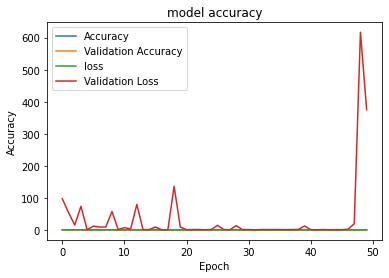

In [ ]:
plt.plot(history_int_3.history["accuracy"])
plt.plot(history_int_3.history['val_accuracy'])
plt.plot(history_int_3.history['loss'])
plt.plot(history_int_3.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Observation:**\
we can observe that on the 44 epoch, training accuracy increases while validity is volatile but increasing slowly towards the end, the model is performing the best with \
Accuracy: 90.32%\
Val_accuracy: 80.28%

**Best Model** \
Since we had tested by adjusting the learning rate and derive that 0.0001 using admin optimizer, we will run this for 1000 epoch to optimise the model.

In [ ]:
# identify classifer
classifier_int = tf.keras.applications.InceptionV3(
              include_top=False,
              weights="imagenet",
              input_shape=(299,299,3),
              pooling='avg',
              classes=2,
              classifier_activation='softmax',
)
# add new classifier layers
flat1 = Flatten()(classifier_int.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
classifier_int = Model(inputs=classifier_int.inputs, outputs=output)

In [ ]:
classifier_int.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_best = classifier_int.fit(train_int, 
                                validation_data= val_int, 
                                epochs=1000)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/1000
62/62 [==============================] - 1187s 19s/step - loss: 0.4058 - accuracy: 0.8174 - val_loss: 1.2644 - val_accuracy: 0.5996
Epoch 2/1000
62/62 [==============================] - 46s 749ms/step - loss: 0.1413 - accuracy: 0.9458 - val_loss: 1.8148 - val_accuracy: 0.6382
Epoch 3/1000
62/62 [==============================] - 47s 749ms/step - loss: 0.0808 - accuracy: 0.9667 - val_loss: 1.1925 - val_accuracy: 0.6484
Epoch 4/1000
62/62 [==============================] - 46s 749ms/step - loss: 0.0783 - accuracy: 0.9700 - val_loss: 1.6002 - val_accuracy: 0.6443
Epoch 5/1000
62/62 [==============================] - 46s 740ms/step - loss: 0.0457 - accuracy: 0.9846 - val_loss: 2.4513 - val_accuracy: 0.6565
Epoch 6/1000
62/62 [==============================] - 47s 749ms/step - loss: 0.0671 - accuracy: 0.9691 - val_loss: 2.0805 - val_accuracy: 0.6402
Epoch 7/1000
62/62 [==============================] - 47s 753ms/step - loss: 0.0355 - accuracy: 0.9872 - val_loss: 2.1489 - val_ac

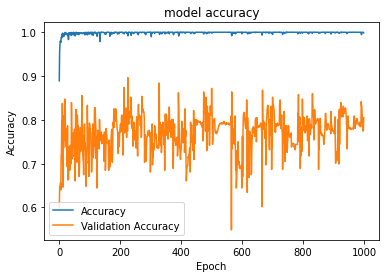

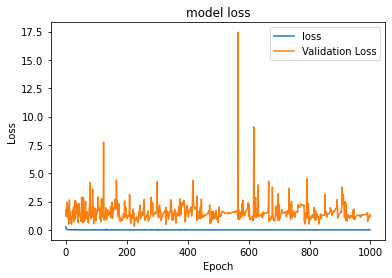

In [ ]:
plt.plot(history_best.history["accuracy"])
plt.plot(history_best.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

Confusion Matrix, without normalization
[[12  0]
 [ 0 10]]


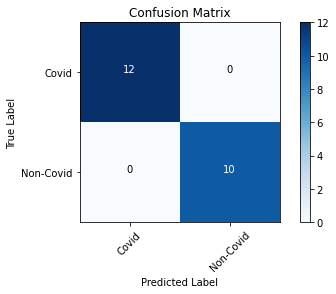

In [ ]:
# predict the predict images
pred = classifier_int.predict(x=test_int, verbose=0)
cm = confusion_matrix(y_true = test_int.classes,y_pred = np.argmax(pred, axis=1))

# plot confusion metrix to visualise result with function
cm_plot_labels = ['Covid', 'Non-Covid']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title= 'Confusion Matrix')

**Conclusion:** 

From observation, the model is optimised on 200-250 epoch, hence with training rate of 0.0001 and 250 epoch we are able to have the best predictive model to predict if the CT Scan image is a positive or negative case of covid 19.

**Thank you**